<a href="https://colab.research.google.com/github/taku-1217/PECARN/blob/main/PECARN%E3%80%80pytorch%E3%80%80%E3%83%99%E3%83%BC%E3%82%B9%E3%83%A2%E3%83%87%E3%83%AB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [61]:
# CSVファイルの読み込み
data = pd.read_csv('TBI PUD 10-08-2013.csv')  # ローカルのファイルパスに変更してください

In [62]:
# 使用する特徴量と目的変数のリスト
features = [
    'AgeTwoPlus', 'High_impact_InjSev', 'LOCSeparate', 'LocLen', 'HA_verb',
    'HASeverity', 'Vomit', 'VomitNbr', 'ActNorm', 'GCSTotal', 'AMS',
    'SFxBas', 'SFxPalp', 'Hema', 'HemaLoc'
]
target = 'PosCT'

# 特徴量と目的変数の抽出
data=data[data[target] != 92]
X = data[features]
y = data[target]

In [63]:
# 欠損値の処理
imputer = SimpleImputer(strategy='most_frequent')
X_imputed = imputer.fit_transform(X)

# データの標準化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imputed)

# 訓練データとテストデータの分割
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
s
# PyTorch用のデータセットとデータローダーの作成
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train.values, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test.values, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [64]:
# モデルの定義
class SimpleNN(nn.Module):
    def __init__(self, input_size):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))
        return x

In [65]:
# モデルのインスタンス化
model = SimpleNN(input_size=X_train.shape[1])

# 損失関数とオプティマイザの定義
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [66]:
# モデルの訓練
num_epochs = 20
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs).squeeze()
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}')


Epoch 1/20, Loss: 0.21814875941180703
Epoch 2/20, Loss: 0.20172135062029015
Epoch 3/20, Loss: 0.2004353526287043
Epoch 4/20, Loss: 0.1981754338172213
Epoch 5/20, Loss: 0.1973661799639014
Epoch 6/20, Loss: 0.19796639274637304
Epoch 7/20, Loss: 0.1977775399034946
Epoch 8/20, Loss: 0.19632964060833705
Epoch 9/20, Loss: 0.19521184128957178
Epoch 10/20, Loss: 0.19510558073469741
Epoch 11/20, Loss: 0.1958588583011124
Epoch 12/20, Loss: 0.19441505326847336
Epoch 13/20, Loss: 0.1952795139958511
Epoch 14/20, Loss: 0.1925853648639504
Epoch 15/20, Loss: 0.1930450085719027
Epoch 16/20, Loss: 0.1919134188649343
Epoch 17/20, Loss: 0.1925165265910889
Epoch 18/20, Loss: 0.19070437653505024
Epoch 19/20, Loss: 0.18993564270174684
Epoch 20/20, Loss: 0.1901848550942076


In [67]:
# モデルの評価
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        predicted = (outputs > 0.5).float()
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Test Accuracy: {100 * correct / total:.2f}%')

Test Accuracy: 93.62%


Test Accuracy: 93.62%
ROC AUC: 0.81


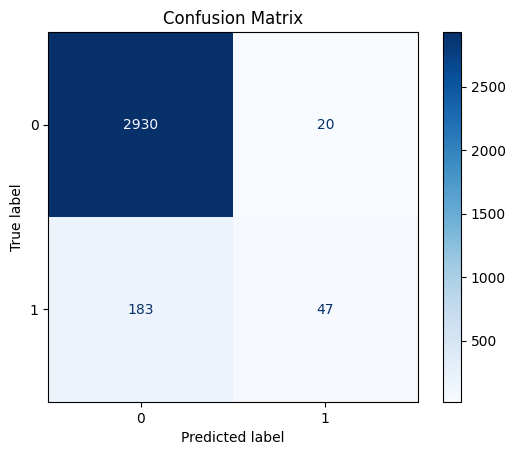


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.94      0.99      0.97      2950
     Class 1       0.70      0.20      0.32       230

    accuracy                           0.94      3180
   macro avg       0.82      0.60      0.64      3180
weighted avg       0.92      0.94      0.92      3180



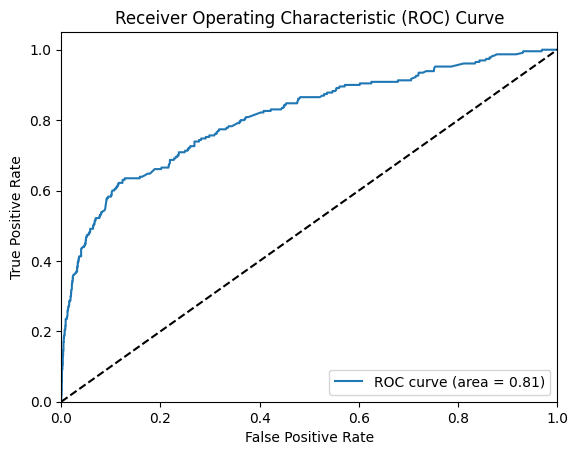

In [72]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve

# モデルの評価
model.eval()
correct = 0
total = 0
y_pred_prob = []  # 予測確率
y_pred = []       # バイナリ予測
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs).squeeze()
        predicted = (outputs > 0.5).float()
        y_pred_prob.extend(outputs.tolist())  # 予測確率をリストに追加
        y_pred.extend(predicted.tolist())     # バイナリ予測をリストに追加
        y_true.extend(labels.tolist())        # 実際のラベルをリストに追加
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

# ROC AUCの計算（予測確率を使用）
roc_auc = roc_auc_score(y_true, y_pred_prob)
print(f'ROC AUC: {roc_auc:.2f}')

# 混同行列の計算と表示
conf_matrix = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 分類レポートの表示
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=['Class 0', 'Class 1']))

# ROC曲線のプロット（予測確率を使用）
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()